In [1]:
# default_exp models.ensembles

# models.ensembles
> API details.

In [2]:
# export
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""
import numpy as np
import torch
from torch import nn
from fastrenewables.tabular.model import *
from fastrenewables.timeseries.model import *
from fastai.tabular.all import *
from torch.autograd import Variable
from sklearn.datasets import make_regression
from fastai.learner import *
from fastrenewables.utils_pytorch import *
import copy
from fastrenewables.timeseries.model import *
from fastrenewables.baselines import BayesLinReg, ELM
from fastrenewables.models.transfermodels import *
from fastrenewables.tabular.learner import *
from fastrenewables.timeseries.learner import *
from sklearn.base import BaseEstimator
import numpy as np

There are a number of different possibilities for ensembling/weighting in timeseries. The following functions cover those relevant for fastrenewables.

The most simple one, will we have $N$ predictions with a forecast horizon of 1 by $k$ ensemble members.
Respectively, the prediction has the shape $N\times k$ or alternatively $N\times k \times 1$. Or alternatively we have an ensemble weight for $N\times k \times t$, so for each forecast horizon and and sample we have an weight. 

In [3]:
#export
def normalize_weight(ensemble_weight):
    """
    Let N be the number of samples, k the number of ensembles, and
    t be the forecast horizon.
    In case of an input array of dimension k, it is reshaped to k x 1, assuming a single forecast horizon.
    In case of a k x t array we normalize for each forecast horizon t acrross all ensmeble members.
    In case of Nxkxt we also normalise accross all members for each horizon.
    """
    
    if len(ensemble_weight.shape) == 1:
        ensemble_weight = ensemble_weight.reshape(len(ensemble_weight), 1)
            
    if len(ensemble_weight.shape) == 2:
        ensemble_weight = ensemble_weight/ensemble_weight.sum(0)
    elif len(ensemble_weight.shape) == 3:
        ensemble_weight = (ensemble_weight/ensemble_weight.sum(1)[:,np.newaxis,:])
        
    return ensemble_weight

In [4]:
#export
def weight_preds(preds, ensemble_weight):
    """
        Weight the predictions by the ensemble weights, depeneding on the shape.
    """
    ensemble_weight = ensemble_weight
    if len(ensemble_weight.shape) == 1:
        ensemble_weight = ensemble_weight.reshape(len(ensemble_weight), 1)
    if len(preds.shape) == 1:
        preds = preds.reshape(len(preds), 1)
    if len(preds.shape) == 2:
        preds = preds[:,:,np.newaxis]
        
    if len(ensemble_weight.shape) == 2:
        preds = ((preds*ensemble_weight).sum(1))
    elif len(ensemble_weight.shape) == 3:
        preds = (preds*ensemble_weight).sum(1)
    return preds

The following tests cover the different scenarios.

In [5]:
N,k,t = 100,3,1
yhat = np.random.random((N,k,t))
ensemble_weight = np.random.random((k,t))
test_close(normalize_weight(ensemble_weight).sum(0), np.array(1.))
normalized_weight = normalize_weight(ensemble_weight.ravel())
test_close(normalized_weight.sum(0), np.array(1.))
test_eq(weight_preds(yhat, normalized_weight).shape, (100,1))

N,k,t = 100,3,5
ensemble_weight = np.random.random((k,t))
yhat = np.random.random((N,k,t))
# when summing accross all, 
# the normalized weight should be equal to the number forecast horizons
normalized_weight = normalize_weight(ensemble_weight)
test_close(normalized_weight.sum(), t)
test_eq(weight_preds(yhat, normalized_weight).shape, (100,5))

N,k,t = 5,3,4
yhat = np.random.random((N,k,t))
ensemble_weight = np.random.random((N, k, t))
# for each forecast horizon for each samples it should sum up to one.
normalized_weight = normalize_weight(ensemble_weight)
test_close(normalized_weight.sum(1), np.ones((N,t)))
# we should get the weighted result by Nxt
test_eq(weight_preds(yhat, normalized_weight).shape, (5,4))


N,k,t = 40,2,1
yhat = np.random.random((N,k,t)).reshape((N,k))
ensemble_weight = np.random.random((k,t))
test_close(normalize_weight(ensemble_weight).sum(0), np.array(1.))
normalized_weight = normalize_weight(ensemble_weight.ravel())
test_eq(weight_preds(yhat, normalized_weight).shape, (40,1))

# Source Models

## Prep Data

In [6]:
def generate_single_dataset(n_samples, start, end, bias, coef, noise_factor=0.3):

    X = np.random.uniform(low=start, high=end,size=n_samples)
    y = np.sin(X*coef*2*np.pi) + np.random.randn(X.shape[0])*noise_factor+bias
    
    return X,y

In [7]:
def generate_all_tasks(n_samples=200):
    starts = [0,  0, 0]
    ends = [4.1,  3.9, 3.7]
    coefs = [3.4,  4, 4.5]
    biases = [0.1,  0.1, 0.1]
    n_samples = [n_samples, n_samples, n_samples]
    
    df_tasks = []
    for task_id in range(len(starts)):
        start, end, bias, coef = starts[task_id], ends[task_id], coefs[task_id], biases[task_id]
        X,y = generate_single_dataset(n_samples[task_id], start, end, bias, coef, noise_factor=0.05)
        df_task = pd.DataFrame({"X": X.ravel(), "y":y.ravel()})
        df_task["TaskID"] = task_id
        df_tasks.append(df_task)
    return pd.concat(df_tasks)

In [8]:
def get_source_task(df):
    df_source =  df[(df.TaskID == 0) ]
    dls_source_01 = TabularDataLoaders.from_df(df_source, cont_names="X", y_names="y", 
                                     deivce="cpu", procs=Normalize, bs=10)
    
    df_source =  df[(df.TaskID == 1)]
    dls_source_02 = TabularDataLoaders.from_df(df_source, cont_names="X", y_names="y", 
                                     deivce="cpu", procs=Normalize, bs=10)
    
    return dls_source_01, dls_source_02
    
def get_target_task(df):
    df_target =  df[df.TaskID == 2]
    dls = TabularDataLoaders.from_df(df_target, cont_names="X", y_names="y", 
                                     deivce="cpu", procs=Normalize, bs=10)
    return dls

In [9]:
df = generate_all_tasks()

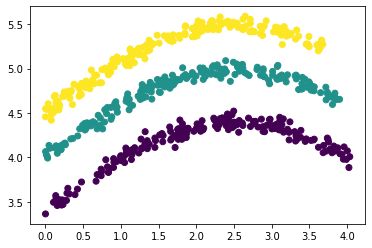

In [10]:
plt.scatter(df.X, df.y, c=df.TaskID)

In [11]:
dls_source_01, dls_source_02 = get_source_task(df)
dls_target = get_target_task(df)

## Train Source Models

In [12]:
set_seed(41, reproducible=True)
source_model = MultiLayerPerceptron([1, 100, 50, 10, 1], use_bn=True, bn_cont=True)
learn_source_01 = Learner(dls_source_01, source_model, metrics=rmse)
learn_source_01.fit(10, lr=0.05)

epoch,train_loss,valid_loss,_rmse,time
0,6.554866,0.282452,0.531462,00:00
1,3.209738,1.037858,1.018753,00:00
2,1.866211,0.051432,0.226785,00:00
3,1.179400,0.025405,0.159389,00:00
4,0.790122,0.050374,0.224441,00:00
5,0.550048,0.046928,0.216629,00:00
6,0.397139,0.033474,0.182958,00:00
7,0.288138,0.026449,0.162631,00:00
8,0.215259,0.014173,0.119052,00:00
9,0.164870,0.048965,0.221280,00:00


In [13]:
set_seed(456, reproducible=True)
source_model = MultiLayerPerceptron([1, 100, 50, 10, 1], use_bn=True, bn_cont=True)
learn_source_02 = Learner(dls_source_02, source_model, metrics=rmse)
learn_source_02.fit(15, lr=0.025)

epoch,train_loss,valid_loss,_rmse,time
0,17.653273,8.891386,2.981843,00:00
1,8.422894,1.240544,1.113797,00:00
2,4.906835,0.160259,0.400323,00:00
3,3.089968,0.042131,0.205259,00:00
4,2.044519,0.026156,0.161728,00:00
5,1.393540,0.016535,0.128590,00:00
6,0.974335,0.011123,0.105465,00:00
7,0.694404,0.023411,0.153005,00:00
8,0.502269,0.024589,0.156808,00:00
9,0.368305,0.040390,0.200974,00:00


In [14]:
elm_source_model_01 = ELM(n_hidden=10, activations=np.sin, 
                          include_original_features=False,
                         prediction_model=BayesLinReg(alpha=100, beta=10, empirical_bayes=False))
elm_source_model_01 = elm_source_model_01.fit(dls_source_01.conts.values, dls_source_01.ys.values.ravel())

elm_source_model_02 = ELM(n_hidden=50, include_original_features=False,
                         prediction_model=BayesLinReg(alpha=1, beta=1, use_fixed_point=True))
elm_source_model_02 = elm_source_model_02.fit(dls_source_02.conts.values, dls_source_02.ys.values)

## Eval Source Model

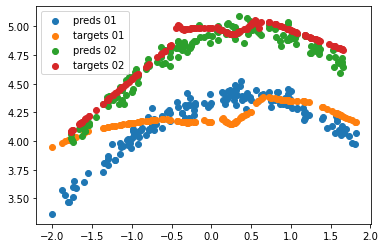

In [15]:
targets, preds = learn_source_01.get_preds(ds_idx=0)
plt.scatter(dls_source_01.train_ds.items.X, preds, label="preds 01")
plt.scatter(dls_source_01.train_ds.items.X, targets, label="targets 01")

targets, preds = learn_source_02.get_preds(ds_idx=0)
plt.scatter(dls_source_02.train_ds.items.X, preds, label="preds 02")
plt.scatter(dls_source_02.train_ds.items.X, targets, label="targets 02")
plt.legend()
plt.show()

# Target

## Adapt source models

In [16]:
# export
def update_single_model(model, dls):
    target_model = LinearTransferModel(
                    model, num_layers_to_remove=1, 
                    prediction_model=BayesLinReg(1, 1, use_fixed_point=True))
    
    target_learner = RenewableLearner(dls, target_model, loss_func=target_model.loss_func, metrics=rmse,)
    target_learner.dls[0].bs=len(target_learner.dls.train_ds)
    target_learner.fit(1)
    
    return target_learner.model

In [17]:
target_model_01 = update_single_model(learn_source_01.model, dls_target)

epoch,train_loss,valid_loss,_rmse,time
0,0.000000,0.009083,0.095306,00:00


In [18]:
target_model_02 = update_single_model(learn_source_02.model, dls_target)

epoch,train_loss,valid_loss,_rmse,time
0,0.000000,0.011207,0.105864,00:00


## Train Ensemble

### Helper Functions

In [19]:
#export
def rank_by_evidence(cats, conts, targets, models, logme=True):
    evidences = np.zeros(len(models))
    for idx,model in enumerate(models):
        if isinstance(model, BaseEstimator):
            evidences[idx] = model.log_evidence(to_np(conts), to_np(targets), logme=logme)
        else:
            evidences[idx] = model.log_evidence(cats, conts, targets, logme=logme)
    sort_ids = evidences.argsort()[::-1]
    return evidences.reshape(len(models), 1), sort_ids

In [20]:
# hide
models = [target_model_01, target_model_02]
cats, conts, targets = convert_to_tensor(dls_target.train_ds)
evidences, sort_ids = rank_by_evidence(cats, conts,targets, models)
# test_eq(sort_ids, np.array([1,0]))

In [21]:
# export
def get_posterioirs(cats, conts, targets, models):
    posteriors = []
    ts_length = 1
    if len(conts.shape)==3:
        ts_length = conts.shape[2]
        
    for idx,model in enumerate(models):
        if isinstance(model, BaseEstimator):
            posterior = np.exp(model.log_posterior(to_np(conts), to_np(targets)))
        else:
            posterior = np.exp(model.log_posterior(cats, conts, targets))
        posteriors.append(posterior.reshape(-1,1))
    posteriors = np.concatenate(posteriors, axis=1)
    return posteriors.reshape(len(models),ts_length)

In [22]:
# hide
models = [target_model_01, target_model_02]
cats, conts, targets = convert_to_tensor(dls_target.train_ds)
posteriors = get_posterioirs(cats, conts, targets,  models)
test_eq(posteriors.shape, (2,1))

In [23]:
# export
def get_predictive_uncertainty(cats, conts, models):
    yhats,ystds = [], []
    ts_length = 1
    if len(conts.shape)==3:
        ts_length = conts.shape[2]
        
    for idx,model in enumerate(models):
        if isinstance(model, BaseEstimator):
            yhat, ystd = model.predict_proba(to_np(conts))
            yhats.append(yhat.reshape(-1,ts_length))
            ystds.append(ystd.reshape(-1,ts_length))
        else:
            yhat, ystd = model.predict_proba(cats, conts)
            yhats.append(to_np(yhat).reshape(-1,ts_length))
            ystds.append(to_np(ystd).reshape(-1,ts_length))

    #  TODO if this working for timersiers?
    yhats, ystds = np.concatenate(yhats, axis=1), np.concatenate(ystds, axis=1)
    yhats, ystds = yhats.reshape(len(conts),len(models),ts_length), ystds.reshape(len(conts),len(models),ts_length)
    y_uncertainty = 1/ystds
    
    return yhats, y_uncertainty

In [24]:
# hide
models = [target_model_01, target_model_02]
cats, conts, targets = convert_to_tensor(dls_target.train_ds)
yhats, y_uncertainty = get_predictive_uncertainty(cats, conts, models)


In [25]:
# export
def get_preds(cats, conts, models, convert_to_np=True):
    yhats, ystds = [], []
    ts_length = 1
    
    if len(conts.shape) == 3:
        ts_length = conts.shape[2]
        
    for idx, model in enumerate(models):
        if isinstance(model, BaseEstimator):
            yhat = model.predict(to_np(conts)).reshape(-1, ts_length)
            yhats.append(yhat)
        elif hasattr(model, "predict"):
            yhat = model.predict(cats, conts).reshape(-1, ts_length)
            if convert_to_np:
                yhat = to_np(yhat)
            yhats.append(yhat)
        elif hasattr(model, "forward"):
            yhat = model.forward(cats, conts).reshape(-1, ts_length)
            if convert_to_np:
                yhat = to_np(yhat)
            yhats.append(yhat)
        else:
            raise ValueError("Unknown prediction function.")
    if convert_to_np:
        yhats = np.concatenate(yhats, axis=1)
    else:
        yhats = torch.cat(yhats, axis=1)

    yhats = yhats.reshape(len(conts), len(models), ts_length)

    return yhats

### Bayesian Model Averaging

In [26]:
# export
class BayesModelAveraing(nn.Module):
    def __init__(self, source_models, 
                 rank_measure="evidence", 
                 weighting_strategy="evidence",
                 n_best_models=-1,
                is_timeseries=False):
        """
            rank_measure [str]: either rmse or logevidence
            n_best_models [int]: the n best models w.r.t. rank_measure are taken into account. 
                                default -1 takes all models
        
        """
        super().__init__()
        self.source_models = np.array(source_models)
        self.rank_measure=rank_measure
        
        self.weighting_strategy = weighting_strategy
        self.n_best_models = n_best_models
        self.is_timeseries = is_timeseries
        
        # fake param so that it can be used with pytorch trainers
        self.fake_param=nn.Parameter(torch.zeros((1,1), dtype=torch.float))
        self.fake_param.requires_grad =True
        
        self.conversion_to_tensor = convert_to_tensor_ts if self.is_timeseries else convert_to_tensor
        
        self.ensemble_weights = None
   
    def fit_tensors(self, cats, conts, targets):
        if self.training:
            if self.rank_measure == "evidence":
                self.rank_measure_values, self.sord_ids = rank_by_evidence(
                    cats, conts, targets, self.source_models
                )
       

            if self.n_best_models != -1:
                self.source_models = self.source_models[
                    self.sord_ids[0 : self.n_best_models]
                ]
                self.rank_measure_values = self.rank_measure_values[
                    self.sord_ids[0 : self.n_best_models]
                ]

        if self.weighting_strategy == "evidence":
            self.ensemble_weights, _ = rank_by_evidence(
                cats, conts, targets, self.source_models
            )

        elif self.weighting_strategy == "posterior":
            self.ensemble_weights = get_posterioirs(
                cats, conts, targets, self.source_models
            )

        if self.weighting_strategy != "uncertainty":
            self.ensemble_weights = normalize_weight(self.ensemble_weights)

    def fit(self, dls):
        cats, conts, targets = self.conversion_to_tensor(dls.train_ds)
        self.fit_tensors(cats, conts, targets)
        
            
    def _predict(self, cats, conts):
        if self.weighting_strategy=="uncertainty":
            yhat, y_uncertainty = get_predictive_uncertainty(cats, conts, self.source_models)
            if len(y_uncertainty.shape) == 2:
                y_uncertainty = y_uncertainty[:,:, np.newaxis]
                
            self.ensemble_weights = normalize_weight(y_uncertainty)
        else:
            yhat = get_preds(cats, conts, self.source_models)
        
        yhat = weight_preds(yhat, self.ensemble_weights)
        
        return yhat
    
    def forward(self, cats, conts):
        yhat = self._predict(cats, conts)
        
        return yhat

    def predict(self, dls, ds_idx=0):
        ds = dls.train_ds
        if ds_idx==1:
            ds = dls.valid_ds
        
        cats, conts, _ = self.conversion_to_tensor(ds)
            
        yhat = self._predict(cats, conts)
        
        return yhat   
    
    def log_evidence(self, dls, ds_idx=0,logme=False):
        ds = dls.train_ds
        if ds_idx==1:
            ds = dls.valid_ds
        
        cats, conts, targets = self.conversion_to_tensor(ds)
        evidences, _ = rank_by_evidence(cats, conts, targets, self.source_models, logme=logme)
        
        return evidences.mean()
        

In [27]:
bma_model = BayesModelAveraing(source_models=[target_model_01, target_model_02], 
                               weighting_strategy='evidence',
                               n_best_models=-1)
bma_model.fit(dls_target)
cats, conts, targets = convert_to_tensor(dls_target.valid_ds)
yhat = bma_model.predict(dls_target, ds_idx=1).shape
((targets.ravel()-bma_model.predict(dls_target, ds_idx=1).ravel())**2).mean()**0.5

tensor(0.0997, dtype=torch.float64)

In [28]:
bma_model = BayesModelAveraing(source_models=[target_model_01, target_model_02], 
                               weighting_strategy='posterior',
                               n_best_models=-1)
bma_model.fit(dls_target)
cats, conts, targets = convert_to_tensor(dls_target.valid_ds)
yhat = bma_model.predict(dls_target, ds_idx=1).shape
((targets.ravel()-bma_model.predict(dls_target, ds_idx=1).ravel())**2).mean()**0.5

tensor(0.0953, dtype=torch.float64)

In [29]:
bma_model = BayesModelAveraing(source_models=[target_model_01, target_model_02], 
                               weighting_strategy='uncertainty',
                               n_best_models=-1)
bma_model.fit(dls_target)
cats, conts, targets = convert_to_tensor(dls_target.valid_ds)
yhat = bma_model.predict(dls_target, ds_idx=1)
((targets.ravel()-yhat.ravel())**2).mean()**0.5

tensor(0.0997)

We can also calculate the evidence of the ensemble.

In [30]:
bma_model.log_evidence(dls_target, ds_idx=1)

35.265928701437794

In [31]:
bma_model = BayesModelAveraing(source_models=[elm_source_model_01, elm_source_model_02], 
                               weighting_strategy='evidence',
                               n_best_models=-1)
bma_model.fit(dls_target)
cats, conts, targets = convert_to_tensor(dls_target.valid_ds)
yhat = bma_model.predict(dls_target, ds_idx=1)
((targets.ravel()-yhat.ravel())**2).mean()**0.5

tensor(1.2067, dtype=torch.float64)

### Coopetitive Soft Gating

In [32]:
# export
def squared_error(y,yhat):
    return (y-yhat)**2

In [33]:
#export
def soft_gating(errors, eta, eps=1e-9):
    errors_sum = errors.sum(0)+eps
    res = (errors_sum/(errors**eta))
    return res/res.sum()

In [34]:
# export
# hide
def _flatten_ts(x):
    if len(x.shape) == 2:
        return x
    
    n_samples, n_features, ts_length = x.shape
    
    if isinstance(x, np.ndarray):
        x = x.swapaxes(1,2)
    else:
        x = x.permute(0,2,1)
    x = x.reshape(n_samples*ts_length, n_features)
    return x

def _unflatten_to_ts(x, ts_length, n_features):
    if len(x) == 0 or n_features == 0:
        return x
    
    x = x.reshape(-1, ts_length, n_features)
    if isinstance(x, np.ndarray):
        x = x.swapaxes(1,2)
    else:
        x = x.permute(0,2,1)
    
    return x

In [35]:
# export
# hide
def create_error_matrix(targets, preds, error_function=squared_error):
    """
        N=#samples, k=#ensembles, t=forecast horizon
        targets needs to be of size Nxt or Nx1xt
        yhat needs to be of shape Nxkxt
    """
    # shape N --> Nxkxt    
    if len(targets.shape)==1:
        targets = targets.reshape(-1,1,1)
        
    # shape Nxt --> Nxkxt 
    if len(targets.shape)==2:
        # 1 is so that we can brodcast accross k ensembles
        targets = targets.reshape(len(targets), 1, -1)
        
    # shape N --> Nxkxt    
    if len(preds.shape)==1:      
        preds = preds.reshape(-1,1,1)
        
    # shape Nxk --> Nxkxt 
    if len(preds.shape)==2: 
        # 1 is for a single forecast horizon
        preds = preds.reshape(len(preds), preds.shape[1],1)
    error_matrix = error_function(targets, preds)
    
    if error_function == squared_error:
        error_matrix = error_matrix**0.5
        
    return error_matrix

In [36]:
# hide
N,k,t = 2,4,3 
targets = np.random.random((N,t))
yhat = np.random.random((N,k,t))
test_eq(create_error_matrix(targets, yhat).shape, (N,k,t))

N,k,t = 2,4,3 
targets = np.random.random((N,1,t))
yhat = np.random.random((N,k,t))
test_eq(create_error_matrix(targets, yhat).shape, (N,k,t))

N,k,t = 2,4,3 
targets = np.random.random((N))
yhat = np.random.random((N,k,t))
test_eq(create_error_matrix(targets, yhat).shape, (N,k,t))

N,k,t = 2,4,1 
targets = np.random.random((N))
yhat = np.random.random((N,k))
test_eq(create_error_matrix(targets, yhat).shape, (N,k,t))

In [37]:
# export
# hide
def get_global_weight(error_matrix, eta=1):
    """expected to be of shape n_samples x n_ensembles x forecast_horizon """

    global_weight =  error_matrix.mean(0).mean(1)
    
    global_weight = Variable(global_weight)
    global_weight.requires_grad = True
    
    return soft_gating(global_weight.reshape(-1,1), eta)

In [38]:
# hide
N,k,t = 10,4,3
targets = np.random.random((N,t))
yhat = np.random.random((N,k,t))
em = create_error_matrix(torch.tensor(targets), torch.tensor(yhat))
test_eq(get_global_weight(em).shape, (k,1))

In [39]:
# export
# hide
def get_timedependent_weight(error_matrix, eta=1):
    """
        Caclulates timedepentend input.
        Input expected to be of shape n_samples x n_ensembles x forecast_horizon 
        Output is of size n_ensembles x forecast_horizon
    """
    if len(error_matrix.shape) != 3:
        raise ValueError("Error matrix is not of dimension n_samples x n_ensembles x forecast_horizon.")
    
    N,k,t =error_matrix.shape
    # average accross all samples
    time_depentent_weight =  error_matrix.mean(0)

    time_depentent_weight = Variable(time_depentent_weight)
    time_depentent_weight.requires_grad = False
    
    new_time_depentent_weight = []
    for t_i in range(t):
        new_time_depentent_weight += [soft_gating(time_depentent_weight[:,t_i], eta).reshape((k,1))]
    
    return torch.cat(new_time_depentent_weight, axis=1)

In [40]:
# hide
test_eq(get_timedependent_weight(em).shape, (k,t))

In [41]:
# export
# hide
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.utils.validation import check_is_fitted
def simple_local_error_estimator(param_dict = {"n_components":5, "n_neighbors": 5}):
    pipe = Pipeline([('pca', PCA(n_components=param_dict["n_components"])), 
                     ('knn', KNeighborsRegressor(n_neighbors=param_dict["n_neighbors"]))])
    return pipe


In [42]:
# export
# hide

def get_local_weight(conts, error_expectation_regressor, eta=1):
    """
      Calculates the expected local error based on an trained error expectation reggressor.
      Based on this matrix with shape n_samples x n_ensembles the weights are calculated.
    """
    with torch.no_grad(): 
        if len(conts.shape)==3:
            conts=_flatten_ts(conts)

        if not isinstance(conts,np.ndarray):
            conts = to_np(conts)
       
        # todo check timeseries that is the same for each timestep
        local_error_expectation = error_expectation_regressor.predict(conts)
        
        if type(local_error_expectation) == np.ndarray:
            local_error_expectation = torch.tensor(local_error_expectation)
    
        if len(local_error_expectation.shape) != 2:
            raise ValueError(f"Local error matrix is not of dimension n_samples x n_ensembles x forecast_horizon. It is of size {local_error_expectation.shape}")
        N,k = local_error_expectation.shape
    
#     local_error_expectation = Variable(local_error_expectation)
    local_error_expectation.requires_grad = False
    
            
    # we should have an error matrix of shape Nxk (n_samples x n_ensembles)
    local_weight = []
    for n in range(len(local_error_expectation)):
        local_weight += [soft_gating(local_error_expectation[n,], eta).reshape(1,k)]
    local_weight = torch.cat(local_weight, axis=0)
    
    return local_weight

In [43]:
#hide
cats, conts, targets = convert_to_tensor(dls_target.valid_ds)
preds_01 = target_model_01.predict(cats, conts)
preds_02 = target_model_02.predict(cats, conts)
preds_comb = np.concatenate([preds_01, preds_02], axis=1)
error_matrix = create_error_matrix(targets, preds_comb)
error_expectation_regressor = simple_local_error_estimator(param_dict = {"n_components":1, "n_neighbors": 5})
error_expectation_regressor = error_expectation_regressor.fit(conts, error_matrix.reshape(-1,error_matrix.shape[1]))
local_weight = get_local_weight(conts, error_expectation_regressor)
test_eq(local_weight.shape, (len(conts),2))
test_close(local_weight.sum(), len(conts))
test_close(local_weight.sum(1)[0], 1)

In [44]:
# export
# hide
class LocalErrorPredictor(BaseEstimator):
    """
       This is a wrapper for a multivariate Bayesian linear regression/extreme learning machine 
       to provide local error forecasts for the CSGE.
    """
    def __init__(self, n_models=1, use_elm=True, n_hidden=200):
        self.n_models = n_models
        self.use_elm = use_elm
        self.n_hidden = n_hidden
    
    def fit(self, conts, errors):
        if not isinstance(conts,np.ndarray):
            conts = to_np(conts)
            
        if not isinstance(errors,np.ndarray):
            errors = to_np(errors)
        
        self.models = []
        for idx in range(self.n_models):
            model = BayesLinReg(use_fixed_point=True)
            if self.use_elm:
                model = ELM(n_hidden=self.n_hidden, prediction_model=model)
            model = model.fit(conts, errors[:,idx])
            self.models.append(model)
            
    def predict(self, conts):
        if len(conts.shape)==3:
            conts=_flatten_ts(conts)
            
        if not isinstance(conts,np.ndarray):
            conts = to_np(conts)
            
        preds = []
        for model in self.models:
            pred = model.predict(conts)
            preds.append(torch.tensor(pred).reshape(-1,1))
            
        preds = torch.cat(preds, axis=1)
        preds[preds<0] = 1
        preds[preds>1] = 1
        
        
        return preds

In [45]:
# export
def turnOffTrackingStats(module):
        if hasattr(module, "track_running_stats"):
            module.track_running_stats = False
        for childMod in module.children():
            turnOffTrackingStats(childMod)

            
class CSGE(nn.Module):
    def __init__(self, source_models,
                       local_error_estimator,
                       eta_global=10, eta_time=10, eta_local=10,
                 is_timeseries_model=False, 
                 is_timeseries_data=False,
                 ts_length=1):
        """
        """
        super().__init__()
        
        self.source_models = torch.nn.Sequential(*source_models)
#         self.source_models = np.array(source_models)
        self.is_timeseries_data = is_timeseries_data
        self.is_timeseries_model = is_timeseries_model
        self.local_error_estimator = local_error_estimator
        self.conversion_to_tensor = convert_to_tensor_ts if self.is_timeseries_data else convert_to_tensor
        
        self.ts_length = ts_length
        self.n_ensembles = len(self.source_models)
        self.error_matrix = None
        self.global_weights = None
        self.timedependent_weights = None
        self.local_weights = None
        self.n_features = None
        
        self.eta_global = nn.Parameter(torch.Tensor([eta_global]))
        self.eta_local = nn.Parameter(torch.Tensor([eta_local]))
        self.eta_time = nn.Parameter(torch.Tensor([eta_time]))
        
    def create_preds(self, cats, conts):
        if self.is_timeseries_model:
            preds = get_preds(cats, conts, self.source_models, convert_to_np=False)
        else:
            preds = get_preds(_flatten_ts(cats), _flatten_ts(conts), 
                              self.source_models, convert_to_np=False)
            
            preds = _unflatten_to_ts(preds, self.ts_length, self.n_ensembles)
            
        return preds
   
    def create_error_matrix(self, preds, targets):
        self.error_matrix = create_error_matrix(targets, preds)
        if not isinstance(self.error_matrix, type(torch.tensor(1))):
            raise ValueError(f"Unexpected data type: {type(self.error_matrix)}")
        
    def _single_data_as_ts(self, data, n_features):
        if data is None:
            return data
        elif len(data.shape) == 3:
            raise ValueError()
        else:
            return _unflatten_to_ts(data, self.ts_length, n_features)  
        
    def _n_features(self,data):
        if data is None:
            return 0
        elif len(data) == 0:
            return 0
        else:
            return data.shape[1]
        
    def all_data_as_ts(self, cats, conts, targets=None):
        if self.is_timeseries_model:
            return cats,  conts, targets
        else:
            return self._single_data_as_ts(cats, n_features=self._n_features(cats)), \
                   self._single_data_as_ts(conts, n_features=self.n_features), \
                   self._single_data_as_ts(targets, n_features=self._n_features(targets))
        
    
    def fit(self, dls, ds_idx=0, n_epochs=1):
        turnOffTrackingStats(self)
        if ds_idx == 0:
            ds = dls.train_ds
        else:
            ds = dls.valid_ds
            
        cats, conts, targets = self.conversion_to_tensor(ds)
        self.n_features = conts.shape[1]
        cats, conts, targets = self.all_data_as_ts(cats, conts, targets)
      
        # we do an initial fit to setup everything and check dimensions
        with torch.no_grad():
            preds = self.create_preds(cats, conts)
            self.create_error_matrix(preds, targets)
            
            self.global_weights = get_global_weight(self.error_matrix, self.eta_global)
            
            self.local_error_estimator.fit(_flatten_ts(conts), _flatten_ts(self.error_matrix))
            self.local_weights = self.get_local_weight(conts)
            
            self.timedependent_weights = get_timedependent_weight(
                self.error_matrix, self.eta_time
            )
        
            assert len(conts) == self.error_matrix.shape[0]
            assert self.n_ensembles == self.error_matrix.shape[1]
            assert self.ts_length == self.error_matrix.shape[2]
            
            assert self.n_ensembles == self.global_weights.shape[0]
            assert 1 == self.global_weights.shape[1]
            assert 2==len(self.global_weights.shape)
            
            assert len(conts) == self.local_weights.shape[0]
            assert self.n_ensembles == self.local_weights.shape[1]
            assert 3==len(self.local_weights.shape)
            
            assert self.n_ensembles == self.timedependent_weights.shape[0]
            assert self.ts_length == self.timedependent_weights.shape[1]
            assert 2==len(self.timedependent_weights.shape)
            
    def get_local_weight(self, conts):
        local_weights = get_local_weight(_flatten_ts(conts), self.local_error_estimator, self.eta_local)
        
        local_weights = _unflatten_to_ts(local_weights, self.ts_length, self.n_ensembles)
        
        return local_weights
        
    def calc_final_weights(self, ):

        final_weights = self.global_weights*self.timedependent_weights
        final_weights = normalize_weight(final_weights)
        
        final_weights = self.local_weights*final_weights
        final_weights = normalize_weight(final_weights)
            
        return final_weights
    
    def forward(self, cats, conts):
        cats, conts, targets = self.all_data_as_ts(cats, conts, None)
        
        self.global_weights = get_global_weight(self.error_matrix, self.eta_global)
        
        self.timedependent_weights = get_timedependent_weight(
                self.error_matrix, self.eta_time
            )
        
        yhat = self._predict(cats, conts)

        return yhat
        
            
    def _predict(self, cats, conts):
        yhat = self.create_preds(cats, conts)
        
        self.local_weights = self.get_local_weight(conts)
        
        final_weights = self.calc_final_weights()
        
        yhat = weight_preds(yhat, final_weights)
        
        return yhat
    

    def predict(self, dls, ds_idx=0):
        ds = dls.train_ds
        if ds_idx==1:
            ds = dls.valid_ds
        with torch.no_grad():
            cats, conts, targets = self.conversion_to_tensor(ds)
            cats, conts, targets = self.all_data_as_ts(cats, conts, targets)

            yhat = self._predict(cats, conts)

            return yhat, targets.reshape(yhat.shape[0],yhat.shape[1])   



In [46]:
for eta in [0.8,0.9,1,2,3,4,5,6,7,8,9,10,20]:
    csge_model = CSGE(source_models=[target_model_01, target_model_02],
                      local_error_estimator=LocalErrorPredictor(2),
                     eta_global=eta, eta_local=eta, eta_time=eta)
    
    csge_model.fit(dls_target, ds_idx=1)
    
    yhat, targets = csge_model.predict(dls_target, ds_idx=1)
    print(eta, ((targets.ravel()-yhat.ravel())**2).mean()**0.5)

0.8 tensor(0.0988, dtype=torch.float64)
0.9 tensor(0.0986, dtype=torch.float64)
1 tensor(0.0985, dtype=torch.float64)
2 tensor(0.0975, dtype=torch.float64)
3 tensor(0.0966, dtype=torch.float64)
4 tensor(0.0962, dtype=torch.float64)
5 tensor(0.0956, dtype=torch.float64)
6 tensor(0.0955, dtype=torch.float64)
7 tensor(0.0954, dtype=torch.float64)
8 tensor(0.0954, dtype=torch.float64)
9 tensor(0.0954, dtype=torch.float64)
10 tensor(0.0953, dtype=torch.float64)
20 tensor(0.0953, dtype=torch.float64)


# Check for real world timeseries data

## Data Preparation

In [47]:
from fastrenewables.timeseries.core import *
from fastrenewables.tabular.core import *
from fastrenewables.timeseries.data import *
from fastrenewables.timeseries.model import *
from fastrenewables.timeseries.learner import *

In [48]:
cont_names = ['T_HAG_2_M', 'RELHUM_HAG_2_M', 'PS_SFC_0_M', 'ASWDIFDS_SFC_0_M',
       'ASWDIRS_SFC_0_M', 'WindSpeed58m',
       'SinWindDirection58m', 'CosWindDirection58m', 'WindSpeed60m']
cat_names = ['Hour']

def get_dls(y_names="PowerGeneration"):
    pd.options.mode.chained_assignment=None
    dls_source0 = RenewableTimeSeriesDataLoaders.from_files(glob.glob("../data/*.h5")[0], 
                                                y_names=y_names, 
                                                cat_names=cat_names, 
                                                cont_names=cont_names,
                                                pre_procs=[CreateTimeStampIndex(index_col_name="TimeUTC"),
                                                             AddSeasonalFeatures(as_cont=False),
                                                             FilterInconsistentSamplesPerDay], 
                                                procs=[Categorify, Normalize], 
                                                bs=12,
                                                y_block=RegressionBlock(),
                                                )
    dls_source1 = RenewableTimeSeriesDataLoaders.from_files(glob.glob("../data/*.h5")[1], 
                                                y_names=y_names, 
                                                cat_names=cat_names, 
                                                cont_names=cont_names,
                                                pre_procs=[CreateTimeStampIndex(index_col_name="TimeUTC"),
                                                             AddSeasonalFeatures(as_cont=False),
                                                             FilterInconsistentSamplesPerDay], 
                                                procs=[Categorify, Normalize], 
                                                bs=12,
                                                y_block=RegressionBlock(),
                                                )
    
    dls_target = RenewableTimeSeriesDataLoaders.from_files(glob.glob("../data/*.h5")[2], 
                                                y_names=y_names, 
                                                cat_names=cat_names, 
                                                cont_names=cont_names,
                                                pre_procs=[CreateTimeStampIndex(index_col_name="TimeUTC"),
                                                           FilterYear(year=2020), 
                                                             AddSeasonalFeatures(as_cont=False),
                                                             FilterInconsistentSamplesPerDay, 
                                                           FilterMonths(months=[1,2,3,4])], 
                                                procs=[Categorify, Normalize], 
                                                bs=12,
                                                y_block=RegressionBlock(),
                                                )
    
    return dls_source0,dls_source1,dls_target


## Timeseries source model

In [49]:
set_seed(23, reproducible=True)
dls_source0, dls_source1,dls_target = get_dls()
ann_structure = [len(cont_names), 10, 5, 1]

In [50]:
set_seed(23, reproducible=True)
learn_source0 = renewable_timeseries_learner(dls_source0, layers=ann_structure, metrics=rmse)
learn_source0.fit(10)

epoch,train_loss,valid_loss,_rmse,time
0,0.064880,0.041518,0.203759,00:00
1,0.044117,0.026211,0.161898,00:00
2,0.032613,0.020254,0.142315,00:00
3,0.025581,0.017398,0.131900,00:00
4,0.021227,0.015840,0.125859,00:00
5,0.018538,0.014951,0.122276,00:00
6,0.016847,0.014382,0.119927,00:00
7,0.015765,0.013962,0.118163,00:00
8,0.015046,0.013651,0.116837,00:00
9,0.014559,0.013458,0.116009,00:00


In [51]:
set_seed(12345, reproducible=True)
learn_source1 = renewable_timeseries_learner(dls_source1, layers=ann_structure, metrics=rmse)
learn_source1.fit(10)

epoch,train_loss,valid_loss,_rmse,time
0,0.031127,0.025526,0.159767,00:00
1,0.023947,0.019131,0.138315,00:00
2,0.020303,0.017095,0.130747,00:00
3,0.018228,0.015887,0.126042,00:00
4,0.016900,0.015069,0.122757,00:00
5,0.016011,0.014510,0.120459,00:00
6,0.015392,0.014106,0.118770,00:00
7,0.014954,0.013799,0.117468,00:00
8,0.014637,0.013618,0.116696,00:00
9,0.014402,0.013466,0.116043,00:00


## Timeseries Target Models and Bayesian Model Averaging

In [52]:
target_model0 = LinearTransferModel(learn_source0.model, 1, 
                           reduce_layers_tcn_model, 
                           use_original_weights=False,
                        prediction_model=BayesLinReg(1, 1, empirical_bayes=False,use_fixed_point=True),
                                  )

target_learner0 = RenewableTimeseriesLearner(dls_target, target_model0, loss_func=target_model0.loss_func, metrics=rmse,)
target_learner0.dls[0].bs=len(target_learner0.dls.train_ds)
target_learner0.fit(1)

epoch,train_loss,valid_loss,_rmse,time
0,0.000000,0.024466,0.156416,00:00


In [53]:
target_model1 = LinearTransferModel(learn_source1.model, 1, 
                           reduce_layers_tcn_model, 
                           use_original_weights=False,
                        prediction_model=BayesLinReg(1, 1, use_fixed_point=True),
                                  )

target_learner1 = RenewableTimeseriesLearner(dls_target, target_model1, loss_func=target_model1.loss_func, metrics=rmse,)
target_learner1.dls[0].bs=len(target_learner1.dls.train_ds)
target_learner1.fit(1)

epoch,train_loss,valid_loss,_rmse,time
0,0.000000,0.018755,0.136948,00:00


In [54]:
bma_model = BayesModelAveraing(source_models=[target_learner0.model, target_learner1.model], 
                               weighting_strategy='evidence',is_timeseries=True,
                               n_best_models=-1)
bma_model.fit(dls_target)
cats, conts, targets = convert_to_tensor_ts(dls_target.valid_ds)
yhat = bma_model.predict(dls_target, ds_idx=1)
((targets.ravel()-bma_model.predict(dls_target, ds_idx=1).ravel())**2).mean()**0.5

tensor(0.1598, dtype=torch.float64)

In [55]:
bma_model = BayesModelAveraing(source_models=[target_learner0.model, target_learner1.model], 
                               weighting_strategy='posterior',is_timeseries=True,
                               n_best_models=-1)
bma_model.fit(dls_target)
cats, conts, targets = convert_to_tensor_ts(dls_target.valid_ds)
yhat = bma_model.predict(dls_target, ds_idx=1)
((targets.ravel()-bma_model.predict(dls_target, ds_idx=1).ravel())**2).mean()**0.5

tensor(0.1676, dtype=torch.float64)

In [56]:
bma_model = BayesModelAveraing(source_models=[target_learner0.model, target_learner1.model], 
                               weighting_strategy='uncertainty',is_timeseries=True,
                               n_best_models=-1)
bma_model.fit(dls_target)
cats, conts, targets = convert_to_tensor_ts(dls_target.valid_ds)
yhat = bma_model.predict(dls_target, ds_idx=1)
((targets.ravel()-bma_model.predict(dls_target, ds_idx=1).ravel())**2).mean()**0.5

tensor(0.1595)

## CSGE on Timeseries

In [57]:
from fastrenewables.utils import filter_preds
from sklearn.ensemble import GradientBoostingRegressor

In [59]:
# export
class TorchSklearnWrapper(nn.Module):
    def __init__(self, source_models):
        """Wrapper to include sklearn models in the CSGE."""
        super().__init__()
        self.source_models = source_models
        
    def forward(self, cats, conts):
        X = to_np(conts)
        if len(X.shape) == 3:
            N,D,t = X.shape
        else:
            N,D,t = X.shape,1
        
        X = _flatten_ts(X)
        
        # TODO: could be multiple models
        yhat = self.source_models.predict(X)
        yhat = torch.tensor(yhat).float().reshape(-1,1)
        # TODO: could be multiple models
        yhat = _unflatten_to_ts(yhat, t, 1)
        
        
        return yhat

The CSGE can combine arbritrary forecast models. So we can also have a mixture of sklearn and torch models.

In [60]:
conts = _flatten_ts(dls_target.train_ds.conts)
ys = _flatten_ts(dls_target.train_ds.ys)

gbrt = GradientBoostingRegressor(n_estimators=20)
gbrt = gbrt.fit(to_np(conts), to_np(ys).ravel())
gbrt_torch = TorchSklearnWrapper(gbrt)

In [62]:
eta = 2
csge_model = CSGE(source_models=[target_learner0.model, target_learner1.model, gbrt_torch],
                  local_error_estimator=LocalErrorPredictor(3),
                 eta_global=eta, eta_local=eta, eta_time=eta,
                  is_timeseries_data=True, is_timeseries_model=True, 
                  ts_length=24)

csge_model.fit(dls_target, ds_idx=0)

yhat, target = csge_model.predict(dls_target, ds_idx=1)

print(eta, ((targets.ravel()-yhat.ravel())**2).mean()**0.5)

2 tensor(0.1561, dtype=torch.float64)


In [63]:
for eta in [0.8,0.9,1,2,4,6,8,10,12,16]:
    csge_model = CSGE(source_models=[target_learner0.model, target_learner1.model],
                      local_error_estimator=LocalErrorPredictor(2),
                     eta_global=eta, eta_local=eta, eta_time=eta,
                      is_timeseries_data=True, is_timeseries_model=True, 
                      ts_length=24)

    csge_model.fit(dls_target, ds_idx=0)
       
    yhat, target = csge_model.predict(dls_target, ds_idx=1)
#     target, yhat = filter_preds(target.ravel(), yhat.ravel())
    print(eta, ((targets.ravel()-yhat.ravel())**2).mean()**0.5)

0.8 tensor(0.1602, dtype=torch.float64)
0.9 tensor(0.1612, dtype=torch.float64)
1 tensor(0.1612, dtype=torch.float64)
2 tensor(0.1653, dtype=torch.float64)
4 tensor(0.1654, dtype=torch.float64)
6 tensor(0.1691, dtype=torch.float64)
8 tensor(0.1703, dtype=torch.float64)
10 tensor(0.1705, dtype=torch.float64)
12 tensor(0.1684, dtype=torch.float64)
16 tensor(0.1750, dtype=torch.float64)


In [64]:
for eta in [0.8,0.9,1,2,4,6,8,10,12,14,16]:
    set_seed(42)

    csge_model = CSGE(source_models=[learn_source0.model, learn_source1.model],
                      local_error_estimator=LocalErrorPredictor(2),
                     eta_global=eta, eta_local=eta, eta_time=eta,
                      is_timeseries_data=True, is_timeseries_model=True, 
                      ts_length=24)

    csge_model.fit(dls_target, ds_idx=0)
    
    yhat, targets = csge_model.predict(dls_target, ds_idx=1)
#     target, yhat = filter_preds(target.ravel(), yhat.ravel())
    print(eta, ((targets.ravel()-yhat.ravel())**2).mean()**0.5)

0.8 tensor(0.1744, dtype=torch.float64)
0.9 tensor(0.1742, dtype=torch.float64)
1 tensor(0.1741, dtype=torch.float64)
2 tensor(0.1726, dtype=torch.float64)
4 tensor(0.1706, dtype=torch.float64)
6 tensor(0.1696, dtype=torch.float64)
8 tensor(0.1691, dtype=torch.float64)
10 tensor(0.1688, dtype=torch.float64)
12 tensor(0.1687, dtype=torch.float64)
14 tensor(0.1687, dtype=torch.float64)
16 tensor(0.1687, dtype=torch.float64)


In [65]:
freeze(learn_source0.model)
freeze(learn_source1.model)
source_models = [learn_source0.model, learn_source1.model]
local_error_estimator  = LocalErrorPredictor(len(source_models), use_elm=True, n_hidden=20)

csge_model = CSGE(source_models=source_models,
                  local_error_estimator=local_error_estimator,
                     eta_global=2, eta_local=2, eta_time=2,
                      is_timeseries_data=True, is_timeseries_model=True, 
                      ts_length=24)
csge_model.fit(dls_target, ds_idx=0)

dls_target_re = copy.deepcopy(dls_target)
dls_target_re[0].bs=16
csge_learner = RenewableTimeseriesLearner(dls_target_re, csge_model, metrics=rmse)
csge_learner.fit(1, lr=0.5)
print(csge_model.eta_global,csge_model.eta_local, csge_model.eta_time)

epoch,train_loss,valid_loss,_rmse,time
0,0.051758,0.019502,0.139648,00:00


Parameter containing:
tensor([3.9823], requires_grad=True) Parameter containing:
tensor([4.3439], requires_grad=True) Parameter containing:
tensor([4.1557], requires_grad=True)


In [66]:
freeze(learn_source0.model)
freeze(learn_source1.model)

source_models = [learn_source0.model, learn_source1.model]
#  local error based on knn and pca
local_error_estimator  = simple_local_error_estimator()

csge_model = CSGE(source_models=source_models,
                  local_error_estimator=local_error_estimator,
                     eta_global=2, eta_local=2, eta_time=2,
                      is_timeseries_data=True, is_timeseries_model=True, 
                      ts_length=24)
csge_model.fit(dls_target, ds_idx=0)

dls_target_re = copy.deepcopy(dls_target)
dls_target_re[0].bs=16
csge_learner = RenewableTimeseriesLearner(dls_target_re, csge_model, metrics=rmse)
csge_learner.fit(1, lr=0.5)
print(csge_model.eta_global,csge_model.eta_local, csge_model.eta_time)

epoch,train_loss,valid_loss,_rmse,time
0,0.050678,0.018557,0.136224,00:00


Parameter containing:
tensor([3.8335], requires_grad=True) Parameter containing:
tensor([4.6167], requires_grad=True) Parameter containing:
tensor([4.0594], requires_grad=True)


In [67]:
freeze(learn_source0.model)
freeze(learn_source1.model)

source_models = [learn_source0.model, learn_source1.model]
local_error_estimator  = LocalErrorPredictor(len(source_models), use_elm=False)

csge_model = CSGE(source_models=source_models,
                  local_error_estimator=local_error_estimator,
                     eta_global=2, eta_local=2, eta_time=2,
                      is_timeseries_data=True, is_timeseries_model=True, 
                      ts_length=24)
csge_model.fit(dls_target, ds_idx=0)

dls_target_re = copy.deepcopy(dls_target)
dls_target_re[0].bs=16
csge_learner = RenewableTimeseriesLearner(dls_target_re, csge_model, metrics=rmse)
csge_learner.fit(1, lr=0.5)
print(csge_model.eta_global,csge_model.eta_local, csge_model.eta_time)

epoch,train_loss,valid_loss,_rmse,time
0,0.051962,0.019271,0.138819,00:00


Parameter containing:
tensor([4.0568], requires_grad=True) Parameter containing:
tensor([4.3266], requires_grad=True) Parameter containing:
tensor([4.1984], requires_grad=True)


In [68]:
import copy
s0 = copy.deepcopy(learn_source0.model)
s1 = copy.deepcopy(learn_source1.model)
freeze(s0)
freeze(s1)
unfreeze(s0.layers.temporal_blocks[-1])

source_models = [s0, s1]
print("Before training")
print(s0.layers.temporal_blocks[-1].downsample.weight)

local_error_estimator  = LocalErrorPredictor(len(source_models), use_elm=False)
local_error_estimator = simple_local_error_estimator()
csge_model = CSGE(source_models=source_models,
                  local_error_estimator=local_error_estimator,
                     eta_global=2, eta_local=2, eta_time=2,
                      is_timeseries_data=True, is_timeseries_model=True, 
                      ts_length=24)
csge_model.fit(dls_target, ds_idx=0)

dls_target_re = copy.deepcopy(dls_target)
dls_target_re[0].bs=16
csge_learner = RenewableTimeseriesLearner(dls_target_re, csge_model, metrics=rmse)
csge_learner.unfreeze()
csge_learner.fit(1, lr=1e-1)
print("After training")
print(csge_learner.model.source_models[0].layers.temporal_blocks[-1].downsample.weight)

Before training
Parameter containing:
tensor([[[-0.1195],
         [ 0.2878],
         [-0.0852],
         [ 0.1717],
         [-0.0188]]], requires_grad=True)


epoch,train_loss,valid_loss,_rmse,time
0,0.053718,0.018461,0.135871,00:00


After training
Parameter containing:
tensor([[[-0.1037],
         [ 0.3845],
         [-0.0922],
         [ 0.0147],
         [ 0.1446]]], requires_grad=True)
